### loading models .. 
### Upload a single channel .tif file .. 


Saving C1-GL1024_TL_late_zoom_cfp.tif to C1-GL1024_TL_late_zoom_cfp (1).tif
(672, 834)


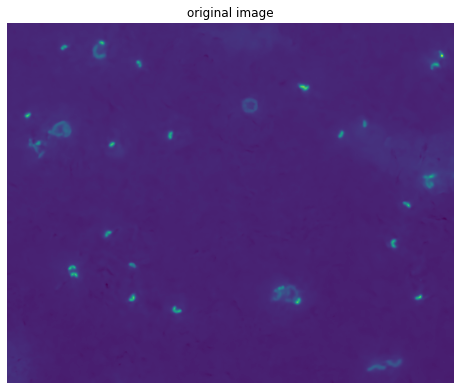

In [ ]:
#@title
# Bdello segmentation

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage.util import random_noise
from skimage.io import imread,imsave
from skimage.filters import gaussian
from skimage.feature import shape_index
from tqdm import tqdm
import glob
import numpy as np
from skimage.util import view_as_windows
from skimage.exposure import adjust_gamma

def normalize2max(im):
    ''' normalize to max '''
    im = im-np.min(im)
    return im/np.max(im)

def getPatch(im,sz):
    ''' get random patch from image of size szXsz '''
    sr,sc = im.shape
    rr = np.random.randint(sr-sz)
    cc = np.random.randint(sc-sz)
    return im[rr:rr+sz,cc:cc+sz],rr,cc



def extract_tiles(im,size = 512,exclude = 12):
    ''' extract tiles from image of size 'size' to be stiched back such that 'exclude' pixels near border of tile are excluded '''
    size = size-2*exclude

    if len(im.shape)<3:
        im = im[:,:,np.newaxis]
    sr,sc,ch = im.shape

    pad_row = 0 if sr%size == 0 else (int(sr/size)+1) * size - sr
    pad_col = 0 if sc%size == 0 else (int(sc/size)+1) * size - sc
    im1 = np.pad(im,((0,pad_row),(0,pad_col),(0,0)),mode = 'reflect')
    sr1,sc2,_ = im1.shape


    rv = np.arange(0,im1.shape[0],size)
    cv = np.arange(0,im1.shape[1],size)
    cc,rr = np.meshgrid(cv,rv)
    positions = np.concatenate((rr.ravel()[:,np.newaxis],cc.ravel()[:,np.newaxis]),axis = 1)

    im1 = np.pad(im1,((exclude,exclude),(exclude,exclude),(0,0)),mode = 'reflect')

    params = {}
    params['size'] = size
    params['exclude'] = exclude
    params['pad_row'] = pad_row
    params['pad_col'] = pad_col
    params['im_size'] = [sr1,sc2]
    params['positions'] = positions

    patches = view_as_windows(im1,(size+2*exclude,size+2*exclude,ch),size)
    patches = patches[:,:,0,:,:,:]
    patches = np.reshape(patches,(-1,patches.shape[2],patches.shape[3],patches.shape[4]))
    return patches,params


def stitch_tiles(patches,params):
    ''' stitch tiles generated from extract tiles '''
    size = params['size']
    pad_row = params['pad_row']
    pad_col = params['pad_col']
    im_size = params['im_size']
    positions = params['positions']
    exclude = params['exclude']


    result = np.zeros((im_size[0],im_size[1],patches.shape[-1]))*1.0


    for i,pos in enumerate(positions):
        rr,cc = pos[0],pos[1]
        result[rr:rr+size,cc:cc+size,:] = patches[i,exclude:-exclude,exclude:-exclude,:]*1.0

    if pad_row>0:
        result = result[:-pad_row,:]
    if pad_col>0:
        result = result[:,:-pad_col]
    return result

class Bdello():
    def __init__(self):

        model_path_phc = get_file('phc_bdello','https://github.com/pswapnesh/Models/raw/master/bdello_model1.h5',cache_dir='./')
        model_path_fluo = get_file('fluo_bdello','https://github.com/pswapnesh/Models/raw/master/bdello_fluo.h5',cache_dir='./')

        #model_path_fluo = './Models/bdello_FL'
        #model_path_phc = './Models/bdello_PhC'

        self.model_phc = load_model(model_path_phc,compile=False)
        self.model_fluo = load_model(model_path_fluo,compile=False)

        self.model_phc.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        self.model_fluo.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        self.size = 256

    def preprocess(self,im):
        sh = normalize2max(im)
        return sh

    def segment(self,im,model_type = 'PhC',exclude = 16):
        sh = self.preprocess(im)
        tiles,params = extract_tiles(sh,size = self.size,exclude = exclude)
        if model_type == 'PhC':
            yp = self.model_phc.predict(tiles)
        else:
            yp = self.model_fluo.predict(tiles)
        return stitch_tiles(yp,params)


from google.colab import files
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.io import imread, imsave
from tqdm import tqdm

print('### loading models .. ')
bd = Bdello()

print('### Upload a single channel .tif file .. ')
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image = imread(file_name)
print(image.shape)
plt.figure(figsize = (8,8))
plt.imshow(image)
plt.title('original image')
plt.axis('off')
plt.show()

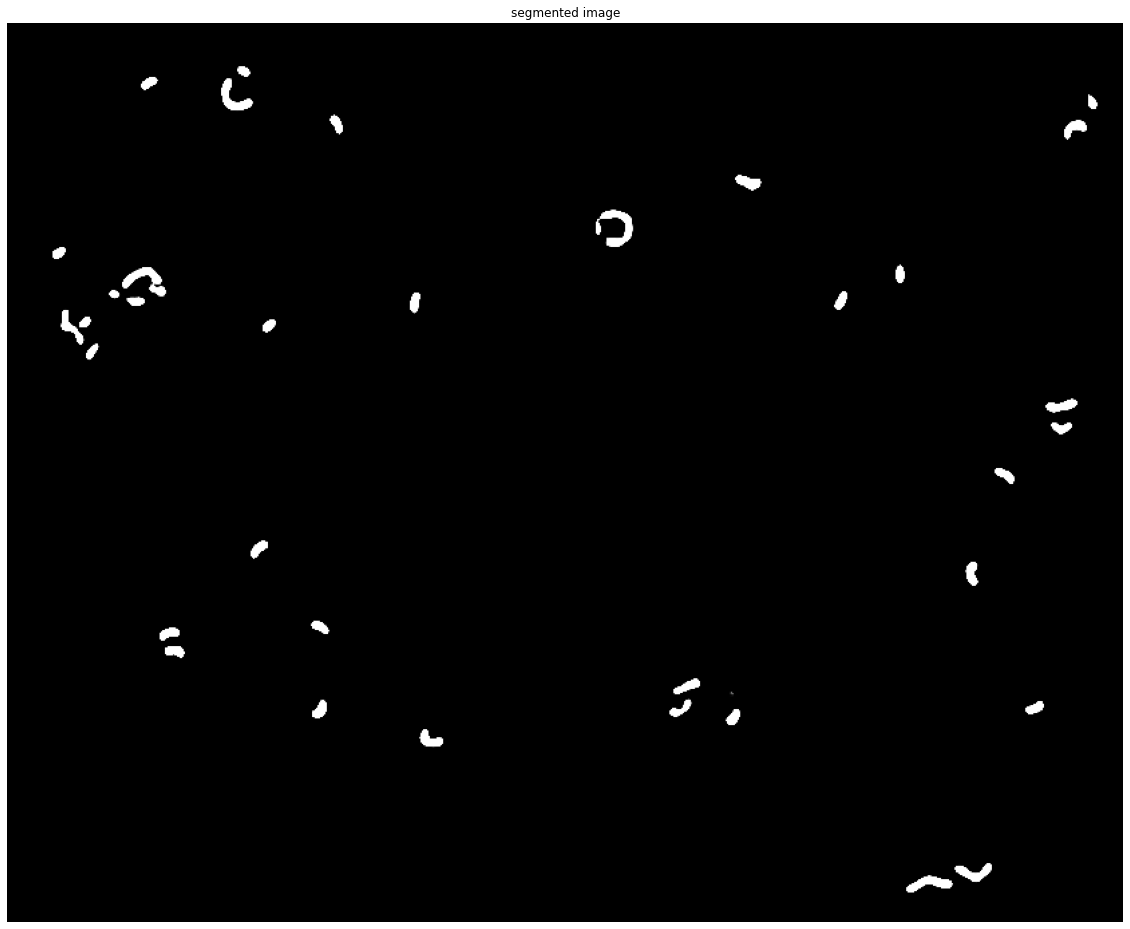

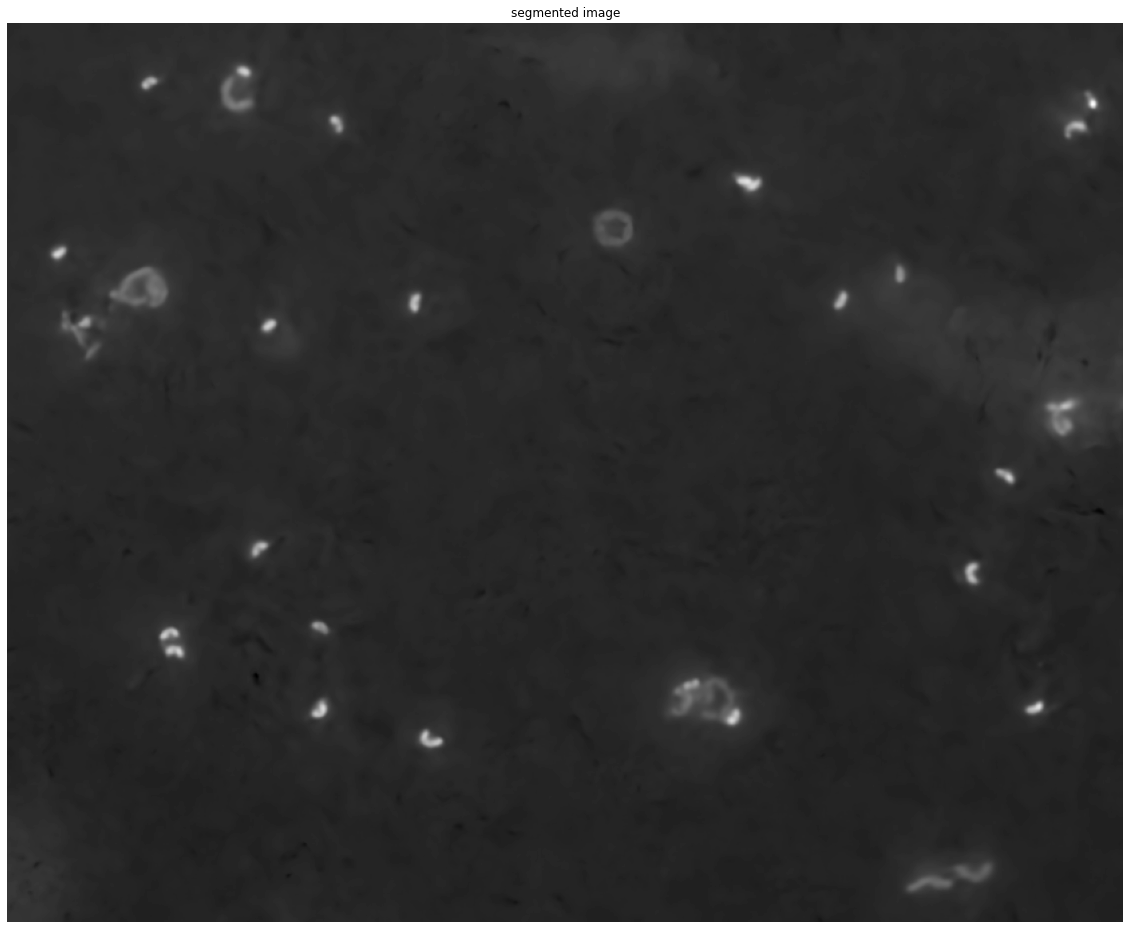

In [ ]:
from scipy.ndimage import gaussian_laplace
from skimage.filters import gaussian,laplace
resolution = 0.0650000 #@param {type:"number"}
image_type = 'FL' #@param ["PhC", "FL"]
scale = 0.065/resolution
sr,sc = image.shape
im = rescale(image,scale)
im = adjust_gamma(im,0.1)
#im = gaussian(laplace(im),2)
yp = bd.segment(im,model_type = 'image_type')
plt.figure(figsize = (20,20))
plt.imshow(yp[:,:,0],cmap = 'gray')
plt.title('segmented image')
plt.axis('off')
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(im,cmap = 'gray')
plt.title('segmented image')
plt.axis('off')
plt.show()
#imsave('test_seg.tif',(yp[:,:,0]*255).astype(np.uint8))

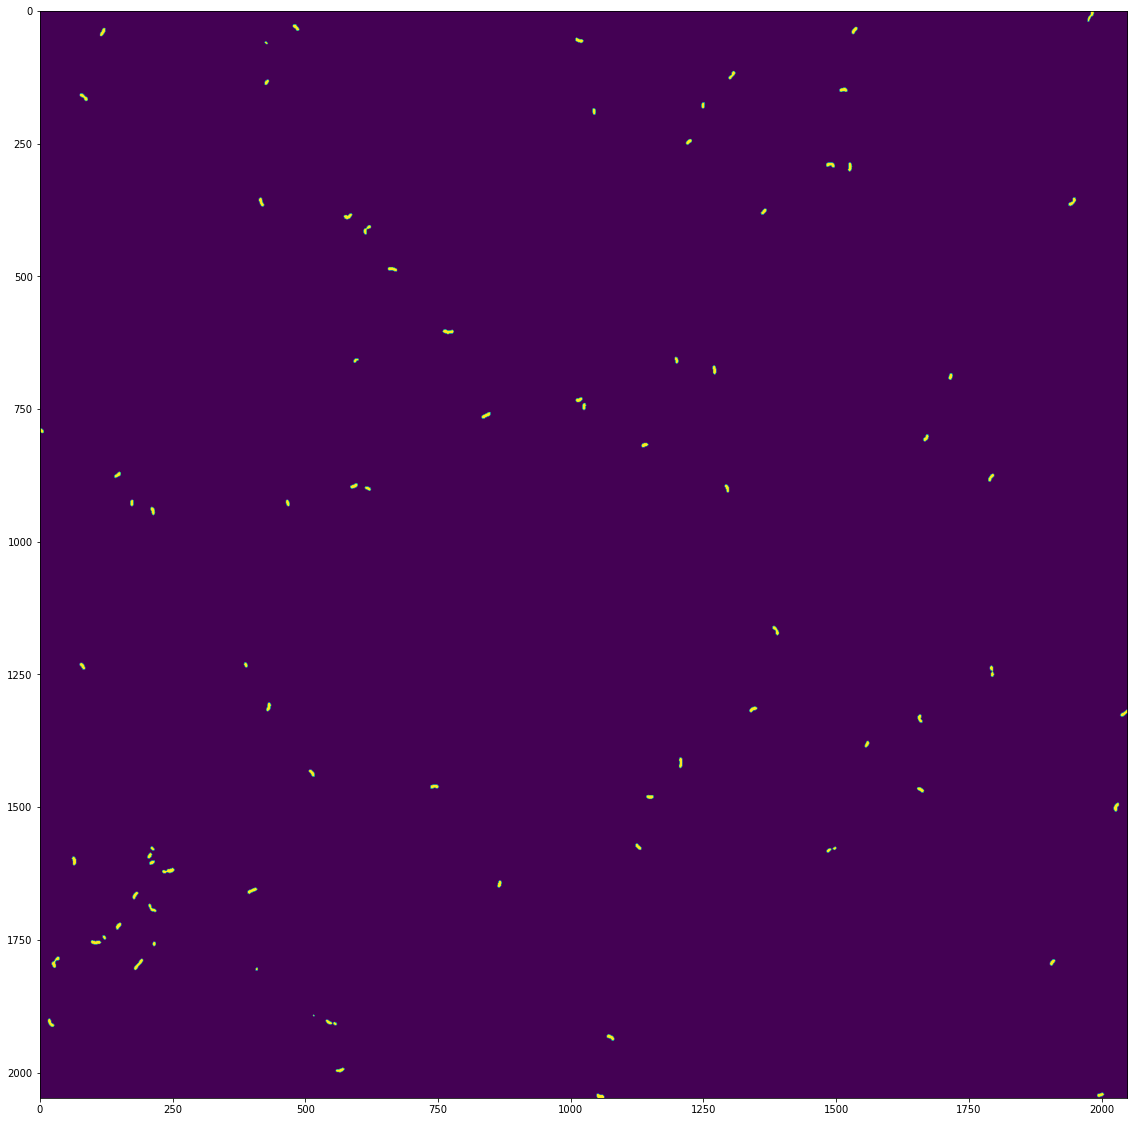

In [ ]:
#@title download file
files.download('test_seg.tif')